In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import pcl
from IPython.display import display
from PIL import Image 

Read frames and calculate point cloud using pyrealsense2 lib.

In [2]:
# Declare pointcloud object, for calculating pointclouds and texture mappings
pc = rs.pointcloud()
# We want the points object to be persistent so we can display the last cloud when a frame drops
points = rs.points()
pipe = rs.pipeline()
cfg = rs.config()
rs.config.enable_device_from_file(cfg, './20191211_160154.bag', repeat_playback = False)
cfg.enable_stream(rs.stream.color, 424, 240, rs.format.rgb8, 6) # color camera
cfg.enable_stream(rs.stream.depth, 424, 240, rs.format.z16, 6) # depth camera
# pipe.start(cfg)
profile = pipe.start(cfg)
playback = profile.get_device().as_playback()
playback.set_real_time(False)

In [3]:
frames = pipe.wait_for_frames()
depth_frame = frames.get_depth_frame()
color_frame = frames.get_color_frame()

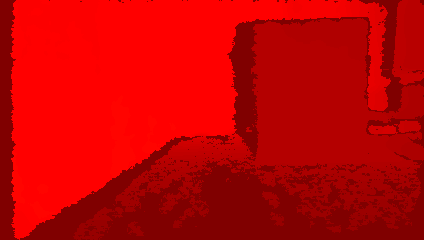

True

In [6]:
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
display(Image.fromarray(depth_colormap))
cv2.imwrite("depth_orig.png", depth_colormap)

In [7]:
# dec_filter = rs.decimation_filter()
thres_filter = rs.threshold_filter()
depth_to_disparity = rs.disparity_transform(True)
spat_filter = rs.spatial_filter()
temp_filter = rs.temporal_filter()
# hole_fill_filter = rs.hole_filling_filter(mode=2)
disparity_to_depth = rs.disparity_transform(False)

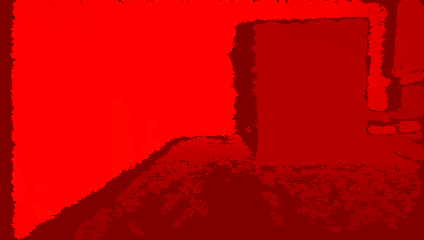

True

In [8]:
from PIL import Image 
from IPython.display import display, clear_output
# from cStringIO import StringIO

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
# print(depth_image)

if True:
    depth_frame = thres_filter.process(depth_frame)
    depth_frame = depth_to_disparity.process(depth_frame)
    depth_frame = spat_filter.process(depth_frame)
    depth_frame = temp_filter.process(depth_frame)
#     depth_frame = hole_fill_filter.process(depth_frame)
    depth_frame = disparity_to_depth.process(depth_frame)
    
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
display(Image.fromarray(depth_colormap))
cv2.imwrite("depth_rs_processed.png", depth_colormap)
# frames = pipe.wait_for_frames()
# depth_frame = frames.get_depth_frame()

In [9]:
points = pc.calculate(depth_frame)

In [10]:
def points_to_pcl(points): 
    cloud = pcl.PointCloud()
    vtx = np.asanyarray(points.get_vertices())
    point_array = np.zeros((len(vtx), 3), np.float32)
    
    for i in range(len(vtx)):
        point_array[i][0] = np.float32(vtx[i][0])
        point_array[i][1] = np.float32(vtx[i][1])
        point_array[i][2] = np.float32(vtx[i][2])
    if False:
        point_array = point_array.reshape(240, 424,3)
        cloud.from_3d_array(point_array)
    else:
        cloud.from_array(point_array)
    print(cloud.height, cloud.width)
    return cloud

In [11]:
cloud = points_to_pcl(points)

1 101760


In [148]:
# M_PI = 3.141592
# def region_growing_segmentation(cloud, organized=False):
#     if not organized:
#         print("Making Kd Tree")
#         tree = cloud.make_kdtree()
   
#     ne = cloud.make_NormalEstimation()
#     if not organized:
#         ne.set_SearchMethod(tree)
#     ne.set_RadiusSearch(0.05)
#     print("Computing normals")
#     # normals
#     cloud_normals = ne.compute()

#     print("Applying RegionGrowing")
#     reg = cloud.make_RegionGrowing(ksearch=5)
#     reg.set_MinClusterSize(1000)
#     reg.set_MaxClusterSize(1000000)
#     reg.set_NumberOfNeighbours(5)
#     reg.set_SmoothnessThreshold(5.0 / 180.0 * M_PI)
#     reg.set_CurvatureThreshold(2.0)
#     reg.set_InputNormals(cloud_normals)
#     print("Extracting")
#     cluster_indices = reg.Extract()
    
# #     for i, c in enumerate(cluster_indices):
# #         print(str(i) + "th cluster size: " + str(len(c)))
# #     longest_list = max(cluster_indices, key= lambda i: len(i))
# #     print("largest cluster len: " ,len(longest_list))
#     return cluster_indices

In [149]:
# cluster_indices = region_growing_segmentation(cloud)

Making Kd Tree
Computing normals
Applying RegionGrowing
Extracting


In [12]:
def mark_pixels(image, width, indices):
    # mark pixels of the indices to white (255, 255, 255)
    MARK_COLOR = np.array([255, 255, 255])
    res_image = image.copy()
    for idx in indices:
        i = idx % width
        j = idx // width
        res_image[j, i] = MARK_COLOR
    return res_image

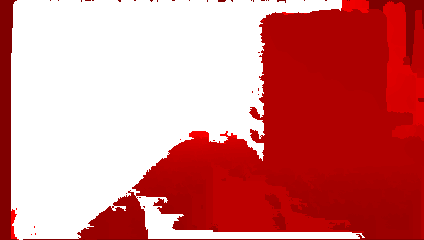

In [153]:
# for indices in cluster_indices:
#     print(len(indices))
# processed = mark_pixels(depth_colormap, 424, cluster_indices[1])
# display(Image.fromarray(processed))

In [14]:
M_PI = 3.141592
print("Making Kd Tree")
tree = cloud.make_kdtree()

ne = cloud.make_NormalEstimation()
ne.set_SearchMethod(tree)
ne.set_RadiusSearch(0.05)
print("Computing normals")
# normals
cloud_normals = ne.compute()

print("Applying RegionGrowing")
reg = cloud.make_RegionGrowing(ksearch=5)
reg.set_MinClusterSize(1000)
reg.set_MaxClusterSize(1000000)
reg.set_NumberOfNeighbours(5)
reg.set_SmoothnessThreshold(5.0 / 180.0 * M_PI)
reg.set_CurvatureThreshold(2.0)
reg.set_InputNormals(cloud_normals)
print("Extracting")
cluster_indices = reg.Extract()

Making Kd Tree
Computing normals
Applying RegionGrowing
Extracting


In [15]:
# np.random.choice(cluster_indices[1], 1)
# cloud_normals[2]
# cloud_normals[]
# np.mean(np.take(np.asarray(cloud_normals), [58473]))
def compute_mean_normal(indices, cloud_normals, count):
    # compute the mean normals by randomly choosing points and compute the mean
    s = np.zeros(4)
    for i in np.random.choice(indices, count):
        s += cloud_normals[i]
    return s / count

In [16]:
def choose_flat_plane(cluster_indices, cloud_normals, threshold=0.95, num_points=200):
    # choose the plane that has a normal whose value is larger than the threshold
    idx = -1
    mean_normals = []
    for i, indices in enumerate(cluster_indices):
        mn = compute_mean_normal(indices, cloud_normals, num_points)
        if abs(mn[1]) > threshold:
            idx = i
            break
        mean_normals.append(mn)
    if idx == -1:
        print("no ground found")
        arr = np.asarray(mean_normals)
        print(arr)
        y_values = np.abs(arr[:, 1].squeeze())
        idx = np.argmax(y_values)
#         idx = mean_normals.index(max(mean_normals, key= lambda x: abs(x[1])))
    return idx

In [17]:
idx = choose_flat_plane(cluster_indices, cloud_normals)
print(idx)
chosen_plane = cluster_indices[idx]

3


In [18]:
# https://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
# def fit_plane(points):
# Compute the plane equation with the points
arr = cloud.to_array()
plane_points = arr[chosen_plane]
A = plane_points[:, :2]
# https://data100.datahub.berkeley.edu/user/yclan2/notebooks/fa19/hw/hw7/hw7.ipynb
A = np.hstack([A, np.ones([len(A), 1])])
# A.shape
b = plane_points[:, 2].reshape(-1, 1)
fit = np.linalg.inv(A.T @ A) @ A.T @ b
fit

array([[-0.20232425],
       [-8.45529007],
       [ 1.24028055]])

In [19]:
fit = np.squeeze(fit)
plane_coef = np.insert(fit, 2, -1)

In [20]:
# Include points that are close to the plane
# https://www.geeksforgeeks.org/distance-between-a-point-and-a-plane-in-3-d/
import math

def shortest_distance(point, plane_coef):
    # point: (x, y, z), plane:ax+by+cz+d=0
    x1, y1, z1 = point
    a, b, c, d = plane_coef
    d = abs((a * x1 + b * y1 + c * z1 + d))
    e = math.sqrt(a * a + b * b + c * c)
    return d / e
def find_close_points(cloud, plane_coef, threshold=0.02):
    indices = []
    for i, point in enumerate(cloud):
        distance = shortest_distance(point, plane_coef)
        if distance < threshold:
            indices.append(i)
    return indices
plane_filtered_indices = find_close_points(cloud, plane_coef)

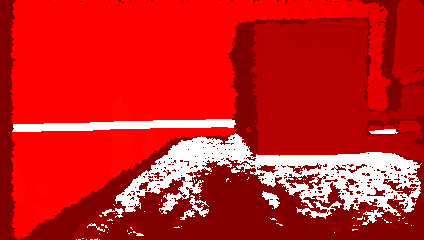

True

In [21]:
processed = mark_pixels(depth_colormap, 424, plane_filtered_indices)
display(Image.fromarray(processed))
cv2.imwrite("proc_before_dilate.png", processed)

In [180]:
# print(len(plane_filtered_indices))
# print(plane_filtered_indices[-1])

101053


In [22]:
# Apply image processing on the depth image
img = processed.copy()
kernel = np.ones((30, 30), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
img_dilation = cv2.dilate(img, kernel, iterations=3) 
img_processed = cv2.erode(img_dilation, kernel, iterations=3) 


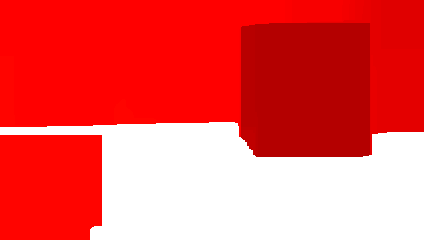

In [23]:
display(Image.fromarray(img_processed))


In [24]:
cv2.imwrite("final_proc.png", img_processed)

True